# Legal Intelligence Rank Monitor


<br>



This jupyter notebook provides the prototype of the rank monitor:

It should:

- Request queries, clicks and their corresponding position on the query list
- Pre-process the data into readable format
- Calculate the NDCG
- Be able to re-run queries, with appropriate access rights and re-calculate the nDCG

<br> 


### Basic Utilities for python

In [11]:
import numpy as np
from sklearn.metrics import f1_score, average_precision_score
import math
import requests
import os

from urllib import *
import json

from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from collections import Counter
from tqdm import tqdm_notebook 
tqdm_notebook().pandas()
from tqdm import tqdm_notebook as tqdm

from time import strftime, gmtime


# Greedy IDE completion 
%config IPCompleter.greedy=True

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; } </style>"))
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [12]:
# Activate Jupyter %%javascript magic
%lsmagic

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%python  %%python

### Javascript for a duplicate line on Ctrl-P


In [13]:
%%js

Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('Ctrl-p', {
    help : 'Duplicate current line',
    help_index : 'zz',
    handler: function(env) {
        var cm=env.notebook.get_selected_cell().code_mirror;
        
        // get a position of a current cursor in a current cell
        var current_cursor = cm.doc.getCursor();
        
        // read a content from a line where is the current cursor
        
        var line_content = cm.doc.getLine(current_cursor.line);
        cm.execCommand('goLineEnd');
        cm.execCommand('newlineAndIndent');
        cm.execCommand('indentLess');
        cm.doc.replaceSelection(line_content);
        cm.doc.setCursor(current_cursor.line + 1, current_cursor.ch);
        return false;
    }}
);

<IPython.core.display.Javascript object>

### DCG function

Implementation for the discounted cumulative gain (DCG) function.


$$ \mathrm{DCG_{p}} = \sum_{i=1}^{N} \frac{rel_{i}}{\log_{b}(i+1)} = rel_1 + \sum_{i=2}^{N} \frac{rel_{i}}{\log_{b}(i+1)}  $$

Mean average precision (MAP) 

$$ F_{1}=\frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $$  

F1 score (only defined for binary relevance scores).

$$ \operatorname{MAP} = \frac{\sum_{q=1}^N \operatorname{AveP(q)}}{N} $$ 





In [14]:
y_true = np.array([3, 2, 3, 0, 0, 1, 2, 2, 3, 0])
print(y_true.shape)

def dcg(y_true: np.array, log_base: 2):
    """
    Returns ndcg given the truth values (clicks) for a given query
    :param y_true: np.array of clicked documents in order
    :param log_base: the log discount factor
    :return:
    """
    gain = y_true[0]
    for index, rel_i in enumerate(y_true):
        if index !=0:
            gain += rel_i / (math.log(rel_i+index+1, log_base))

    return gain

MAP  = []
NDCG = []
F1   = []

for i in range(1,11):
#     MAP.append(average_precision_score(y_true[0:i],y_pred[0:i]))
    NDCG.append(dcg(y_true[0:i],log_base=2))
#     F1.append(f1_score(y_true[0:i], y_pred[0:i]))

# print("MAP : ", MAP[-1])
print("NDCG : ", NDCG[-1])
# print("F1: ", F1[-1])




(10,)
NDCG :  7.586584190664457


In [15]:
def make_solr_url(rows= 100, query= '*:*', sort=''):
    """
    :param rows: amount of rows to request
    :param query: string to query
    :param sort: string to sort the request eg. sort='ShortTimeStamp desc'
    """
    
    url = 'http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr' \
          '/ACC_Logging_Slave/select?indent=on&q={}&rows={}&sort={}&start=0&wt=json'.format(query,rows,sort)

    return url
    
print(make_solr_url())


http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr/ACC_Logging_Slave/select?indent=on&q=*:*&rows=100&sort=&start=0&wt=json


In [16]:
currentdir = Path('./data/')
[file for file in currentdir.glob('*')]
[file for file in Path('./').glob('*')]


[PosixPath('data/EventID:164 AND Year:2019 AND UserID:*.hdf'),
 PosixPath('data/EventID:164 AND Year:2016 AND UserID:* AND SearchText:*.hdf'),
 PosixPath('data/EventID:164 AND Year:2018 AND UserID:*.hdf'),
 PosixPath('data/aggregated_processed.h5'),
 PosixPath('data/EventID:27Full2019.hdf'),
 PosixPath('data/test.edges'),
 PosixPath('data/EventID:27Full2018.hdf'),
 PosixPath('data/EventID:164 AND Year:2017 AND UserID:*.hdf'),
 PosixPath('data/EventID:164Full2019.hdf')]

[PosixPath('rank_monitor.ipynb'),
 PosixPath('Widgets-Overview.ipynb'),
 PosixPath('data'),
 PosixPath('Large-graph.png'),
 PosixPath('queries_multiple_times.ipynb'),
 PosixPath('df164_bitcoin'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('Plan_next_weeks.txt'),
 PosixPath('graphbuilder.ipynb'),
 PosixPath('text_files'),
 PosixPath('df27_bitcoin'),
 PosixPath('test_matrix.ipynb'),
 PosixPath('nos_scrape'),
 PosixPath('Pairwise.png'),
 PosixPath('old'),
 PosixPath('Interpretingwithfancymarkdown.ipynb'),
 PosixPath('17:0017april.ipynb'),
 PosixPath('multiple_query'),
 PosixPath('.interactive_notebook.ipynb.swo'),
 PosixPath('Untitled1.ipynb'),
 PosixPath('Untitled.ipynb'),
 PosixPath('.interactive_notebook.ipynb.swp')]

## Dynamic ranking



In [17]:
def request_into_dataframe(rows= 100, query= '*:*', sort=''):
    """
    :param rows: amount of rows to request
    :param query: string to query
    :param sort: string to sort the request eg. sort='ShortTimeStamp desc'
    """
    
    url = 'http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr' \
    '/ACC_Logging_Slave/select?indent=on&q={}&rows={}&sort={}&start=0&wt=json'.format(query,rows,sort)

    response = requests.get(url)

    # Transform the request into a json
    response = response.json()

    response = response['response']['docs'][1:]

    df =  pd.DataFrame(response)
    
    return df
    
    

In [18]:
def get_27_frame(query:  str) -> pd.DataFrame:
    """
    Get every search log from people with a UserID:* 
    :param query: query string
    :return: dataframe object from solr given the query parameter
    """
    
    df = request_into_dataframe(query='{}'.format(query), rows = 1000000000)
    df.to_hdf('./multiple_query/df27_{}'.format(query), key='test', mode='w')

    return df


In [9]:
def aggregate_dataframe(df: pd.DataFrame):
    """
    Function to aggregate clicks from users on the same day with the same searchtext to a generic 
    
    :param df: dataframe containing the eventID 27 
    """
    
    new_cols = ['UserID', 'DocumentID', 'DocumentPosition', 'DocumentURL', 'EventID', 'ID',
                   'SearchTypeID', 'ShortTimeStamp', 'TimeStamp', 'SearchText']
    
    # Only use columns defined in new_cols list 
    df = df[new_cols]
    
    total_list = []
    for triple, df_user in tqdm(df.groupby(by=['UserID','ShortTimeStamp','SearchText']), desc= 'Aggregating Document Positions'):

        # If there is a single clicked result just add value
        if len(df_user) == 1:
            total_list.extend(df_user.values.tolist())

        else:
            new = df_user.groupby('UserID').agg({
                'DocumentID':lambda x: list(x), 
                'DocumentPosition': lambda x: list(x), 
                'DocumentURL': lambda x: list(x), 
                'EventID': 'first',
                'ID':'first',
                'SearchTypeID': 'first',
                'ShortTimeStamp': 'first',
                'TimeStamp': 'first',
                'SearchText': 'first',
             }).reset_index()

            total_list.extend(new.values.tolist())

        
    aggregate_df = pd.DataFrame(data=total_list, columns=new_cols)
    
    aggregate_df.to_hdf('./data/EventID:27Full2019.hdf', key='test', mode='w')

    return aggregate_df

    
# df = read_and_process()
# df = aggregate_dataframe(df)
# df.to_hdf('./data/EventID:27Full2019.hdf', key='test', mode='w')

# print(df)

In [10]:
# df = get_27_frame(query='EventID:27 AND SearchText:* AND DocumentPosition:*')
list(df)
# df

# df = aggregate_dataframe(df)
# df/

NameError: name 'df' is not defined

In [ ]:
def main():
    
#     Get dataframe containing eventID27
    df = get_27_frame(query='EventID:27 AND SearchText:* AND DocumentPosition:*')
    
    df = aggregate_dataframe(df)
    
    display(df[df['SearchText'] == 'fiscale eenheid'])

    
    counter = df.groupby(['SearchText']).size().sort_values(ascending=False).reset_index(name='count')
    
        
main()







/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['Department', 'DocumentID', 'DocumentSource', 'DocumentURL', 'FunctionArea', 'ID', 'Publisher', 'RunID', 'SearchText', 'TimeStamp']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


HBox(children=(IntProgress(value=0, description='Aggregating Document Positions', max=74967), HTML(value='')))

In [ ]:
df2 = df2[]

## Aggregate document positions 

<b />

HBox(children=(IntProgress(value=0, max=99), HTML(value='')))

Text(0.5,0,'Rank k')

Text(0,0.5,'DCG')

Text(0.5,1,'DCG at K')

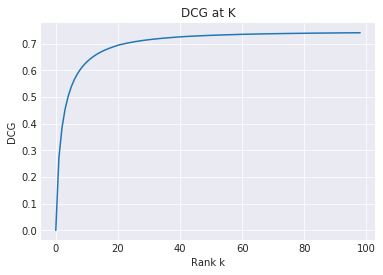

In [13]:
# aggregate_df['DocumentPosition'] = aggregate_df['DocumentPosition'].progress_apply(lambda pos: int(pos) if isinstance(pos, float) else [int(num) for num in pos])

def make_predictions(df: pd.DataFrame):
    """
    Transforms document positions to a vector of zeros and ones
    From [1,4] --> [1,0,0,1]
    :param dataframe: pd.DataFrame of pd.Series that contains a DocumentPosition column 
    :return: list of predictions
    """
    predictions = []
    for val in df['DocumentPosition']:
        maximum = np.max(val)
        y_pred = np.zeros(shape=int(maximum)+1,)
        y_pred[val] = 1
        predictions.append(y_pred)
    return predictions
    

def calculate_ndcg(predictions: list, rank_at_k= 70, log_base= 2):
    """
    Given a list of predictions calculate the average DCG score per rank
    :param predictions: list of binary predictions e.g. [1,0,1,0,0,0,1]
    :param rank_at_k: range of the predictions 
    :param log_base: range of the predictions 
    :return: list of predictions
    """
    average_at_k = []
    for k in tqdm(range(1, rank_at_k), desc= "Calculating nDCG"):
        ndcgs = [] 
        for pred in predictions:
            ndcgs.append(dcg(pred[0:k], log_base))
        ave = np.average(ndcgs)
        average_at_k.append(ave)
    
    return average_at_k
    

predictions = make_predictions(df)
average_at_k =  calculate_ndcg(predictions, 100)



plt.plot(average_at_k)
plt.xlabel('Rank k')
plt.ylabel('DCG')
plt.title("DCG at K")
plt.show()

## General Data Statistics

In [22]:
df_164 = pd.read_hdf(path_or_buf='./data/EventID:164Full2019.hdf')

# Importing gc module 
import gc 
  
# Returns the number of 
# objects it has collected 
# and deallocated 
collected = gc.collect() 
print(gc.get_count())

(22, 0, 0)


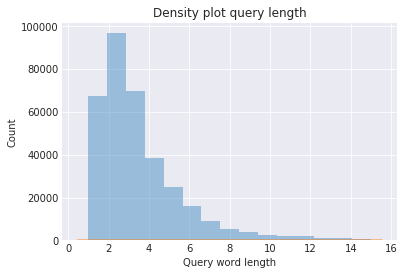

In [42]:
from collections import Counter

def get_query_count(df: pd.DataFrame):
    """
    Get query count statistic
    """

    text = df_164['SearchText'].dropna().tolist()
    found = [len(word) for word in text]

    # Longest Query in the set
    # print("Longests query in/ set:", text[np.argmax(found)])
    
    num_words = [len(sentence.split()) for sentence in text]
    num_words = [length for length in num_words if length <=15]
    sns.distplot(num_words, hist=True, kde=False, bins=15)
    sns.kdeplot(num_words, shade=True);

    plt.xlabel('Query word length')
    plt.ylabel('Count')
    plt.title("Density plot query length")
    plt.show()

        
get_query_count(df_164)


## 2.0 Replicate query to Solr

<b />


In [57]:
# http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr/ACC_Legal_Slave/select?df=konijn&indent=on&q=*:*&rows=200&wt=json

def query_request_solr(query= '', rows = 10):
    """
    Returns a list of size=rows of the document ids returned from query
    :param rows: amount of rows to request
    :param query: string to query
    :param sort: string to sort the request eg. sort='ShortTimeStamp desc'
    """
    
    url = 'http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr/ACC_Legal_Slave' \
    '/select?df={}&indent=on&q=*:*&rows={}&wt=json'.format(query,rows)

    response = requests.get(url)
    
#   Transform the request into a json
    response = response.json()

    response = response['response']['docs'][:]
 
    df =  pd.DataFrame(response)
    return df['ID'].tolist()

In [38]:
df =  query_request_solr(query='eerwraak')
df

NameError: name 'query_request_solr' is not defined

In [50]:
df_164 = pd.read_hdf(path_or_buf='./data/EventID:164Full2019.hdf')
df_164['SearchText'].value_counts().head()

new = df_164[df_164['SearchText'] == 'eerwraak']
# dataframe['name'].value_counts().idxmax()

list_query_terms = df_164['SearchText'].unique().tolist()

list_query_terms

eerwraak                                       1007
artikel 7:677 BW                                651
de rechtspraak en de islamitische hoofddoek     610
ontslag op staande voet                         519
bitcoin                                         508
Name: SearchText, dtype: int64

['NJ 2014/497',
 'politiek',
 'rewe relativiteitsvereiste',
 'de jong "daad-schuld"',
 'adviesaanvraag Ondernemingsraad',
 'de waarborgen uit art. 6 EVRM',
 'deelgeschil psychisch letsel',
 'De Participatiewet voorwaarden',
 'Voorstel van wet',
 'saskia bouwman ',
 'Ter haar',
 'jbpr 2008/8',
 'Bijstandsuitkering',
 'aandeelhoudersrechtenrichtlijn',
 'saskia bouwman kooprecht',
 'kooprecht',
 'wpnr, meerouderschap',
 'ECLI:NL:RVS:2015:75',
 'nj 1997/684',
 'NJ 2000/562',
 'vrijheid van ondernemerschap constitutionele rechter',
 'wpnr',
 'bju',
 'ECLI:NL:RVS:2016:1295',
 ' ECLI:NL:HR:2016:2287',
 'Morgan stanley',
 'NTB 2010/17',
 'beroep op richtlijn in horizontale verhouding',
 'desaveu',
 '"alcoholverslavingsproblematiek*"',
 'Mitsubishi',
 'doorwerking richtlijnen',
 '"alcoholverslavingsproblematiek"',
 '"alcoholproblematiek*"',
 '"alcoholproblematiek*" noot',
 '"alcoholafhankelijkheid*"',
 'Discriminatievrije werkomgeving',
 'S. van der Heul Gst. 2017/81',
 'Betwist feit "meer geda

## Matching columns 

Replicating the query, thus matching

In [52]:
df = pd.read_hdf('./data/EventID:27Full2019.hdf')


In [53]:
# aggregate_df['RealDummyQueries'] = aggregate_df.progress_apply(lambda x: np.random.choice(list_query_terms), axis=1)
# 
# aggregate_df

# TODO Insert column with access-codes to exactly replicate the query



In [58]:
df['new_query_ids'] = df['SearchText'].progress_apply(lambda query: query_request_solr(query))



HBox(children=(IntProgress(value=0, max=507655), HTML(value='')))

KeyboardInterrupt: 

In [39]:
aggregate_df = pd.read_hdf(path_or_buf='./data/aggregated_processed.h5')

# aggregate_df['new_query'] = aggregate_df['SearchText'].progress_apply(lambda query: query_request_solr(query))

aggregate_df['DocumentPosition'] = aggregate_df['DocumentPosition'].progress_apply(lambda pos: [pos] if not isinstance(pos,list) else pos)


aggregate_df.to_hdf(path_or_buf='./data/aggregated_processed.h5', key='test', mode='w')
aggregate_df




,UserID,DocumentID,DocumentPosition,DocumentURL,EventID,ID,SearchTypeID,ShortTimeStamp,TimeStamp,SearchText,RealDummyQueries,new_query
0,448,21878900,[1],https://www.navigator.nl/#/document/idpassad73...,27,f93d9ee0-f60b-4848-954b-cda40180ee5f,14,20190205,2019-02-05T17:58:53.062Z,Example queeer,bestemming wijziging splitsingsakte,"[15683253, 8258074, 15683267, 15683273, 156832..."
1,501,3784979,[1],https://www.navigator.nl/#/document/id24220071...,27,5c582bb1-5de5-42a2-adbc-3ae680d2d03c,14,20190206,2019-02-06T15:13:31.231Z,Example queeer,"wpnr, meerouderschap","[15683253, 8258074, 15683267, 15683273, 156832..."
2,546,"[7135235, 30944074]","[2, 4]",[https://zoek.officielebekendmakingen.nl/stb-2...,27,22827983-55a3-4345-b95d-f2711f664766,14,20190129,2019-01-29T15:08:01.758Z,What,"RvA Bouw 16 maart 2007, 27430","[15683253, 8258074, 15683267, 15683273, 156832..."
3,546,3785076,[3],https://www.navigator.nl/#/document/id24220080...,27,8bdb596c-9942-4ba2-afb2-97a1d42b2b58,14,20190201,2019-02-01T08:29:11.325Z,Example queeer,NJ 2000/562,"[15683253, 8258074, 15683267, 15683273, 156832..."
4,600,24577998,[1],http://deeplink.rechtspraak.nl/uitspraak?id=EC...,27,89a32601-4c83-4d96-bb8a-0c7c6a7f8e8c,14,20190129,2019-01-29T14:32:14.295Z,Is that,bkr registratie telefoonabonnement,"[15683253, 8258074, 15683267, 15683273, 156832..."
5,891,23035512,[12],https://www.navigator.nl/#/document/idfab39498...,27,b50c4780-051f-4be3-b232-15bbaed26ae1,14,20190129,2019-01-29T16:15:14.393Z,Example queeer,rechtsgevolgen in stand,"[15683253, 8258074, 15683267, 15683273, 156832..."
6,891,23250617,[11],https://www.navigator.nl/#/document/idff4346d3...,27,a3f8d151-e58b-49db-9e93-69b0fc72a126,14,20190129,2019-01-29T16:14:36.592Z,What,nj 2007/675,"[15683253, 8258074, 15683267, 15683273, 156832..."
7,891,"[28010621, 29333697, 30957277]","[8, 1, 4]",[http://www.legalintelligence.com/documents/lo...,27,5ff35b39-1053-4838-b5b8-3d8142dff78e,14,20190201,2019-02-01T13:25:25.449Z,Example queeer,"HR 18 mei 1999, NJ 2000/104, m.nt. Schalken (4...","[15683253, 8258074, 15683267, 15683273, 156832..."
8,891,"[31390697, 27479289]","[1, 19]",[https://www.navigator.nl/#/document/ide9be272...,27,da901d04-a20c-4509-9471-5c4067c7af2f,14,20190201,2019-02-01T13:13:46.752Z,How,t j van der ploeg hoe moeilijk is het om een ...,"[15683253, 8258074, 15683267, 15683273, 156832..."
9,891,"[30753616, 22909517, 30275118]","[1, 24, 2]",[https://www.navigator.nl/#/document/id9a468cb...,27,01342caf-2be1-40f2-8a0f-73950cf67b99,14,20190201,2019-02-01T13:22:38.423Z,Is that,EHRM 25 februari 1992 andersson noot,"[15683253, 8258074, 15683267, 15683273, 156832..."


HBox(children=(IntProgress(value=0, max=15353), HTML(value='')))

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['DocumentID', 'DocumentPosition', 'DocumentURL', 'ID', 'TimeStamp', 'SearchText', 'RealDummyQueries', 'new_query']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


,UserID,DocumentID,DocumentPosition,DocumentURL,EventID,ID,SearchTypeID,ShortTimeStamp,TimeStamp,SearchText,RealDummyQueries,new_query
0,448,21878900,[1],https://www.navigator.nl/#/document/idpassad73...,27,f93d9ee0-f60b-4848-954b-cda40180ee5f,14,20190205,2019-02-05T17:58:53.062Z,Example queeer,bestemming wijziging splitsingsakte,"[15683253, 8258074, 15683267, 15683273, 156832..."
1,501,3784979,[1],https://www.navigator.nl/#/document/id24220071...,27,5c582bb1-5de5-42a2-adbc-3ae680d2d03c,14,20190206,2019-02-06T15:13:31.231Z,Example queeer,"wpnr, meerouderschap","[15683253, 8258074, 15683267, 15683273, 156832..."
2,546,"[7135235, 30944074]","[2, 4]",[https://zoek.officielebekendmakingen.nl/stb-2...,27,22827983-55a3-4345-b95d-f2711f664766,14,20190129,2019-01-29T15:08:01.758Z,What,"RvA Bouw 16 maart 2007, 27430","[15683253, 8258074, 15683267, 15683273, 156832..."
3,546,3785076,[3],https://www.navigator.nl/#/document/id24220080...,27,8bdb596c-9942-4ba2-afb2-97a1d42b2b58,14,20190201,2019-02-01T08:29:11.325Z,Example queeer,NJ 2000/562,"[15683253, 8258074, 15683267, 15683273, 156832..."
4,600,24577998,[1],http://deeplink.rechtspraak.nl/uitspraak?id=EC...,27,89a32601-4c83-4d96-bb8a-0c7c6a7f8e8c,14,20190129,2019-01-29T14:32:14.295Z,Is that,bkr registratie telefoonabonnement,"[15683253, 8258074, 15683267, 15683273, 156832..."
5,891,23035512,[12],https://www.navigator.nl/#/document/idfab39498...,27,b50c4780-051f-4be3-b232-15bbaed26ae1,14,20190129,2019-01-29T16:15:14.393Z,Example queeer,rechtsgevolgen in stand,"[15683253, 8258074, 15683267, 15683273, 156832..."
6,891,23250617,[11],https://www.navigator.nl/#/document/idff4346d3...,27,a3f8d151-e58b-49db-9e93-69b0fc72a126,14,20190129,2019-01-29T16:14:36.592Z,What,nj 2007/675,"[15683253, 8258074, 15683267, 15683273, 156832..."
7,891,"[28010621, 29333697, 30957277]","[8, 1, 4]",[http://www.legalintelligence.com/documents/lo...,27,5ff35b39-1053-4838-b5b8-3d8142dff78e,14,20190201,2019-02-01T13:25:25.449Z,Example queeer,"HR 18 mei 1999, NJ 2000/104, m.nt. Schalken (4...","[15683253, 8258074, 15683267, 15683273, 156832..."
8,891,"[31390697, 27479289]","[1, 19]",[https://www.navigator.nl/#/document/ide9be272...,27,da901d04-a20c-4509-9471-5c4067c7af2f,14,20190201,2019-02-01T13:13:46.752Z,How,t j van der ploeg hoe moeilijk is het om een ...,"[15683253, 8258074, 15683267, 15683273, 156832..."
9,891,"[30753616, 22909517, 30275118]","[1, 24, 2]",[https://www.navigator.nl/#/document/id9a468cb...,27,01342caf-2be1-40f2-8a0f-73950cf67b99,14,20190201,2019-02-01T13:22:38.423Z,Is that,EHRM 25 februari 1992 andersson noot,"[15683253, 8258074, 15683267, 15683273, 156832..."


In [40]:
def match_clicks(clicked_ids, rerank_list: list):
    """
    Returns a list of size=rows of the document ids returned from query
    eg. clicked_ids=[1a,3b], rerank_list=[1,1,1a,1,3b] -> [0,0,1,0,1]
    
    :param clicked_ids: list[int] or int of clicked documents 
    :param rerank_list: list of doc_ids returned by the query
    """
    
    ranking_order = np.zeros(shape=len(rerank_list),)
    
    for pos, doc_id in enumerate(rerank_list):
        
        if doc_id in clicked_ids:
            ranking_order[pos] = 1
            
    return ranking_order

match_clicks(clicked_ids,  rerank_list)

NameError: name 'clicked_ids' is not defined

In [41]:
aggregate_df['ranking_order'] = aggregate_df.progress_apply(lambda row: match_clicks(clicked_ids = row['DocumentPosition'], rerank_list=row['new_query'])  , axis=1)

HBox(children=(IntProgress(value=0, max=15353), HTML(value='')))

In [42]:
aggregate_df['aggre_order'] = aggregate_df['ranking_order'].progress_apply(lambda x: sum(x))
find_nons =  aggregate_df['aggre_order'].nonzero()
find_nons

HBox(children=(IntProgress(value=0, max=15353), HTML(value='')))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  


(array([], dtype=int64),)

In [19]:

from tqdm import tqdm

dates = pd.date_range('20190101',periods=6)


df = pd.DataFrame({"DocumentID"      : [419,384,452,938],
                  "DocumentPosition" : [[2,2,1,4,5,],[0,0,0],[5,10],[0]],
                  "ShortTimeStamp"   : [20190214,20190214,20190214,20190214],
                  "SearchText"       : ['How', "Why","How","Test Query"]})

duplicates = df[df['SearchText'].duplicated(keep=False)].index.tolist()

dicto = {}
for idx, row in enumerate(df.values):
    if idx in duplicates:
        if df['SearchText'][idx] in dicto.keys():
            dicto[df['SearchText'][idx]].append(df['DocumentPosition'][idx])
        else:
            dicto.update({df['SearchText'][idx] : [df['DocumentPosition'][idx]]})
        


jack = df['DocumentPosition'].apply(lambda x: sum(x))
jack 
tqdm.pandas(desc="my bar!")

df['agg'] = df['DocumentPosition'].progress_apply(lambda x: sum(x))
# df
# non = df['agg'].nonzero()
# non

0    14
1     0
2    15
3     0
Name: DocumentPosition, dtype: int64

my bar!: 100%|██████████| 4/4 [00:00<00:00, 8499.10it/s]


# GrayLog request

In [ ]:
def get_acces_string():
    
    url = "http://94.198.29.94:12900/search/universal/keyword?query=full_message%22&keyword=yesterday"

    response = requests.get(url)

    # Transform the request into a json
    response = response.json()

    response = response['response']['docs'][1:]

    df =  pd.DataFrame(response)
    
    
    
# Clean response 
# 
#